# Tutorial on how to query time series data from InfluxDB

For the temporal logic based monitoring service, you will likely need to obtain batches of data from InfluxDB, rather than subscribe to each data sample.
If that is the case, this notebook shows you how to use the InfluxDB query API to get the data you need.

## Setting Up the Python Environment

### Influxdb docker containner is running

Ensure that the influxdb docker containner is running. The simplest way is to run the [6-PuttingItAllTogether/start_influxdb_rabbitmq.py](../6-PuttingItAllTogether/start_influxdb_rabbitmq.py) script.

You may have to run your [incubator DT](../6-PuttingItAllTogether/1-PuttingItAllTogether.ipynb) for a bit, to have data to query below.

### Configuration used by the client API

The configuration used is declared in the [startup.conf](../incubator_dt/software/startup.conf) of the incubator, in the section influxdb. It should look like the following:

```
rabbitmq: {
    ...
}
influxdb: {
    url = http://localhost:8086
    token = "-g7q1xIvZqY8BA82zC7uMmJS1zeTj61SQjDCY40DkY6IpPBpvna2YoQPdSeENiekgVLMd91xA95smSkhhbtO7Q=="
    org = incubator
    bucket = incubator
}
physical_twin: {
    ...
}
...
```

where you may have changed the token in the meantime.

In [1]:
import sys
import os

# Get the current working directory. Should be 8-Monitoring
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '8-Monitoring', 'Current directory is not 8-Monitoring'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

In [ ]:
from pyhocon import ConfigFactory

# Get path to the startup.conf file used in the incubator dt:
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
assert os.path.exists(startup_conf), 'startup.conf file not found'

# The startup.conf comes from the incubator dt repository.
config = ConfigFactory.parse_file(startup_conf)

config_influxdb = config['influxdb']
config_influxdb

ConfigTree([('url', 'http://localhost:8086'),
            ('token',
             '-g7q1xIvZqY8BA82zC7uMmJS1zeTj61SQjDCY40DkY6IpPBpvna2YoQPdSeENiekgVLMd91xA95smSkhhbtO7Q=='),
            ('org', 'incubator'),
            ('bucket', 'incubator')])

In [4]:
from influxdb_client import InfluxDBClient

url = config_influxdb['url']
token = config_influxdb['token']
org = config_influxdb['org']
bucket = config_influxdb['bucket']

client = InfluxDBClient(url=url, token=token, org=org)
client

## Querying Data

To query data from InfluxDB, we use the [Flux query language](https://docs.influxdata.com/influxdb/cloud/query-data/flux/). Here is an example of querying data:

In [5]:
# Initialize the Query API
query_api = client.query_api()

# Define your Flux query: Query the relevant temperature data from the last 7 hours
flux_query = f'''
    from(bucket: "{config_influxdb['bucket']}")
    |> range(start: -7h)
    |> filter(fn: (r) => r["_measurement"] == "emulator" or r["_measurement"] == "dtcourse_controller" or r["_measurement"] == "moving_temperature_average_service" or r["_measurement"] == "temperature_prediction_service") 
    |> filter(fn: (r) => r["_field"] == "average_temperature" or r["_field"] == "max_temperature" or r["_field"] == "min_temperature" or r["_field"] == "moving_average_temperature")
'''

# Execute the query
result = query_api.query(org=org, query=flux_query)

# Parse and print the results
for table in result:
    for record in table.records:
        print(record)

FluxRecord() table: 0, {'result': '_result', 'table': 0, '_start': datetime.datetime(2024, 12, 18, 22, 18, 30, 4040, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2024, 12, 19, 5, 18, 30, 4040, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2024, 12, 19, 2, 50, 35, 793186, tzinfo=datetime.timezone.utc), '_value': 39.0, '_field': 'max_temperature', '_measurement': 'dtcourse_controller', 'source': 'dtcourse_controller'}
FluxRecord() table: 0, {'result': '_result', 'table': 0, '_start': datetime.datetime(2024, 12, 18, 22, 18, 30, 4040, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2024, 12, 19, 5, 18, 30, 4040, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2024, 12, 19, 2, 50, 38, 793842, tzinfo=datetime.timezone.utc), '_value': 39.0, '_field': 'max_temperature', '_measurement': 'dtcourse_controller', 'source': 'dtcourse_controller'}
FluxRecord() table: 0, {'result': '_result', 'table': 0, '_start': datetime.datetime(2024, 12, 18, 22, 18, 30,

**Hint:** you can use the dashboard management page to edit the queries and see them in Flux. The above query was created from the dashboard created in previous notebooks.

The visual editor of the query looks like this:

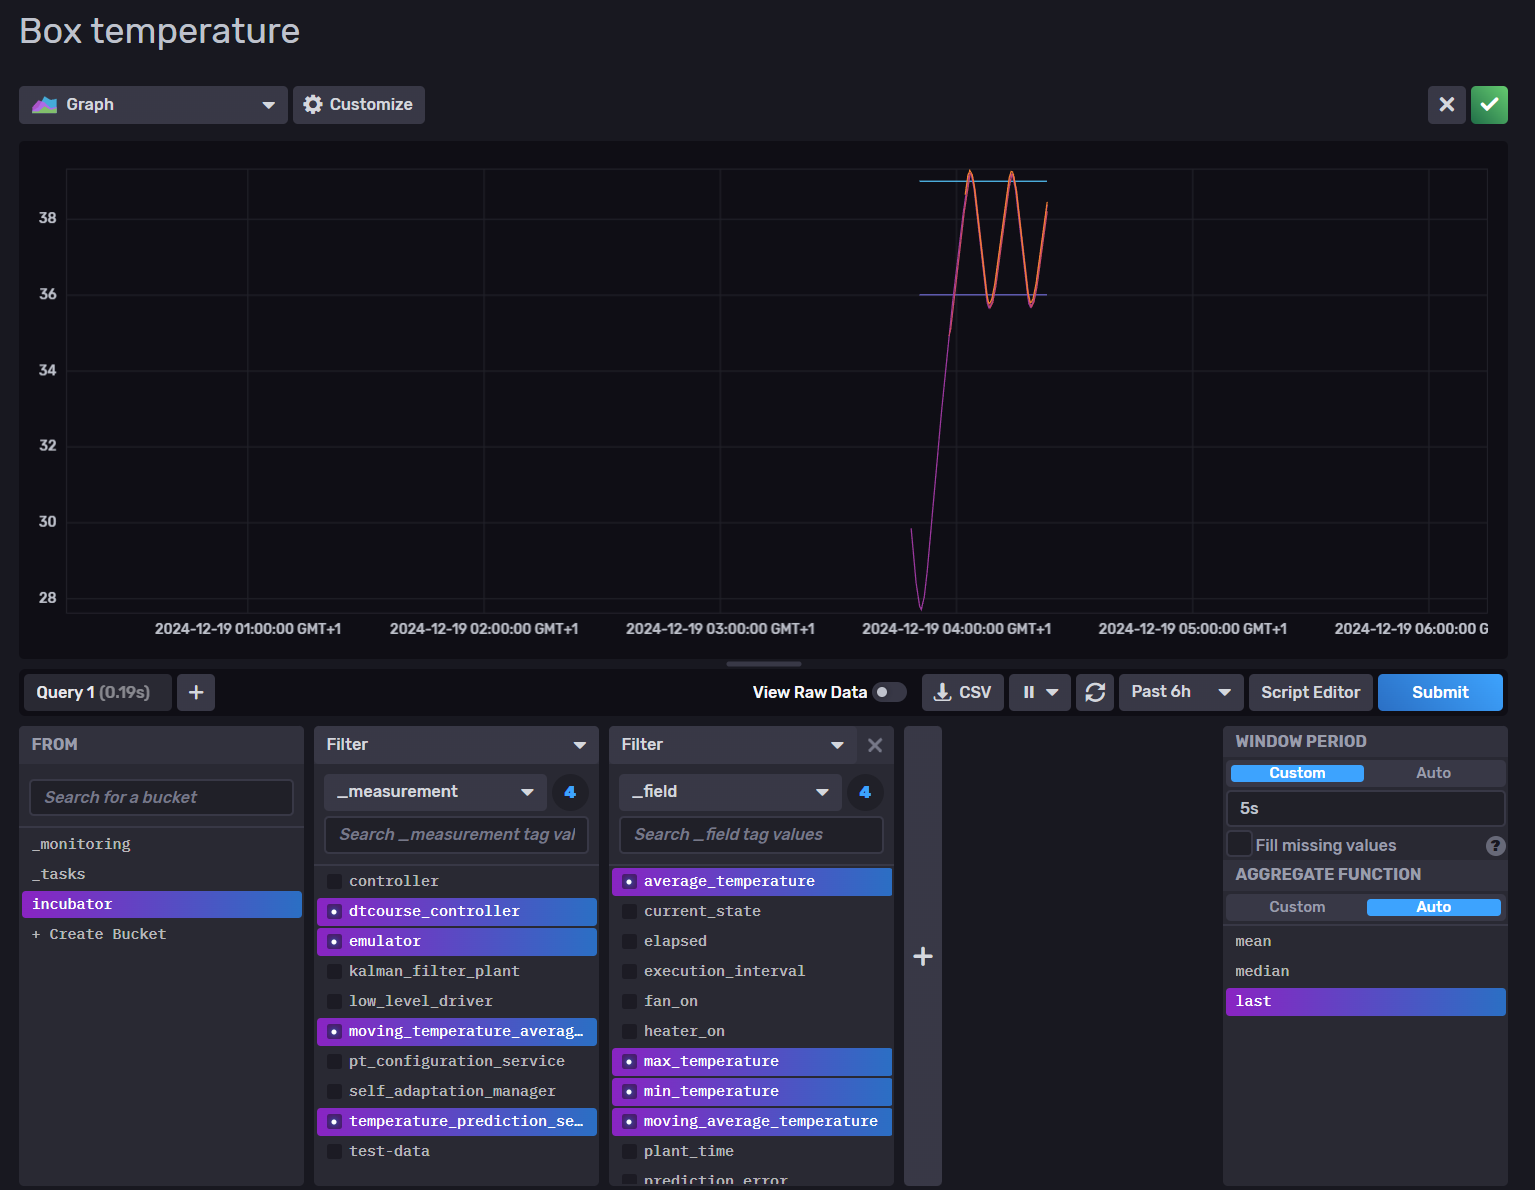

And switching to the script editor you can see the query and adjust it to your needs:

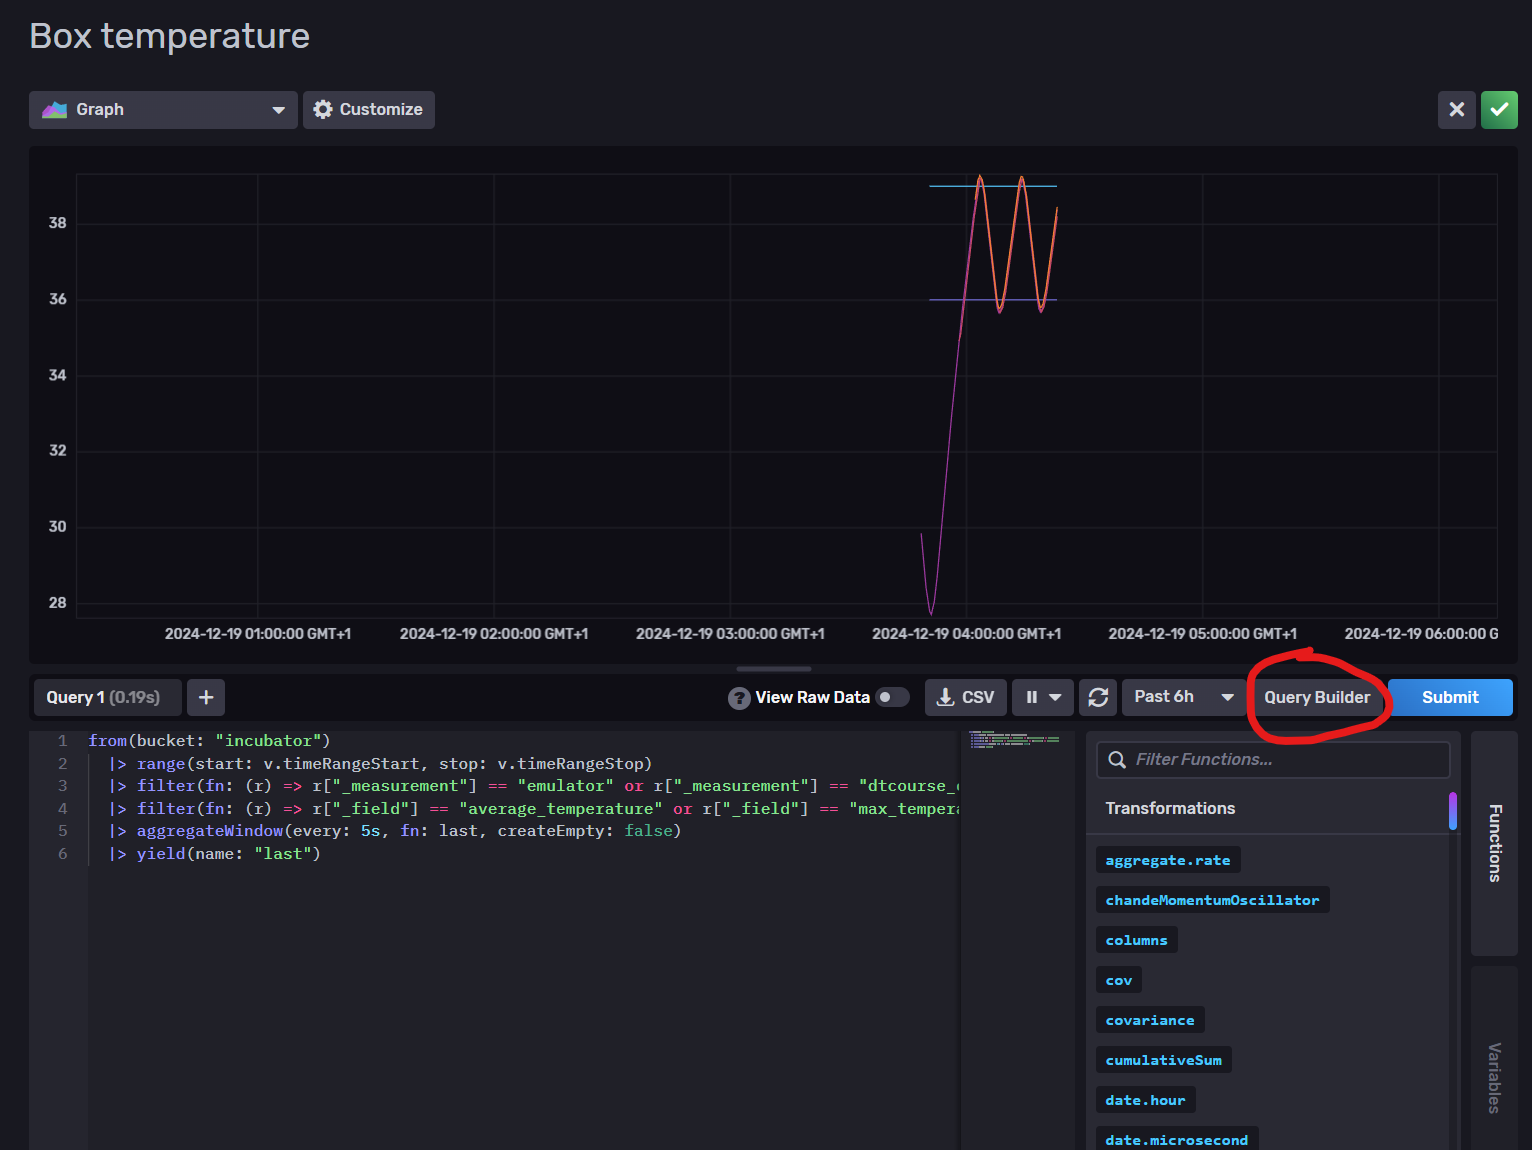


## Handling Query Results

The result is a list of tables:

In [6]:
result

[<FluxTable: 9 columns, 650 records>,
 <FluxTable: 9 columns, 650 records>,
 <FluxTable: 9 columns, 693 records>,
 <FluxTable: 9 columns, 500 records>,
 <FluxTable: 9 columns, 417 records>]

In [8]:
result[0].columns

[FluxColumn(0, label='result', data_type='string', group=False, default_value='_result'),
 FluxColumn(1, label='table', data_type='long', group=False, default_value=''),
 FluxColumn(2, label='_start', data_type='dateTime:RFC3339', group=True, default_value=''),
 FluxColumn(3, label='_stop', data_type='dateTime:RFC3339', group=True, default_value=''),
 FluxColumn(4, label='_time', data_type='dateTime:RFC3339', group=False, default_value=''),
 FluxColumn(5, label='_value', data_type='double', group=False, default_value=''),
 FluxColumn(6, label='_field', data_type='string', group=True, default_value=''),
 FluxColumn(7, label='_measurement', data_type='string', group=True, default_value=''),
 FluxColumn(8, label='source', data_type='string', group=True, default_value='')]

In [14]:
# Access the record object
print(result[0].records[0])

FluxRecord() table: 0, {'result': '_result', 'table': 0, '_start': datetime.datetime(2024, 12, 18, 22, 18, 30, 4040, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2024, 12, 19, 5, 18, 30, 4040, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2024, 12, 19, 2, 50, 35, 793186, tzinfo=datetime.timezone.utc), '_value': 39.0, '_field': 'max_temperature', '_measurement': 'dtcourse_controller', 'source': 'dtcourse_controller'}


In [20]:
print(result[0].records[0].get_time())
print(result[0].records[0].get_field())
print(result[0].records[0].get_value())
print(result[0].records[0].get_measurement())
print(result[0].records[0].values['source'])

2024-12-19 02:50:35.793186+00:00
max_temperature
39.0
dtcourse_controller
dtcourse_controller


With the above you can convert the results into any format you'd like.